# Bathymetry 202405

* Follow the process in Michael's
  https://github.com/SalishSeaCast/analysis-michael/blob/master/bathymetry/bathymetry-201702.ipynb notebook
  with the addition of an adjustment to maximize the depths in the Fraser River from Susan's
  https://github.com/SalishSeaCast/tools/blob/main/bathymetry/bathymetry_201803.ipynb notebook
  to create the base bathymetry for the 202405 coordinates

In [1]:
import os
from pathlib import Path
import sys

import arrow
import cmocean
import numpy
import matplotlib.pyplot as plt
import xarray

Python and library versions:

In [2]:
import bottleneck
import h5netcdf
import h5py
import matplotlib
import netCDF4
import pandas
import pyproj
import scipy

print(f"Python {sys.version=}")
print(f"{numpy.__version__=}")
print(f"{xarray.__version__=}")
print(f"{bottleneck.__version__=}")
print(f"{pandas.__version__=}")
print(f"{h5netcdf.__version__=}")
print(f"{h5py.__version__=}")
print(f"{netCDF4.__version__=}")
print(f"{scipy.__version__=}")
print(f"{matplotlib.__version__=}")
print(f"{arrow.__version__=}")
print(f"{cmocean.__version__=}")
print(f"{pyproj.__version__=}")

Python sys.version='3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:38:13) [GCC 12.3.0]'
numpy.__version__='1.26.4'
xarray.__version__='2024.6.0'
bottleneck.__version__='1.4.0'
pandas.__version__='2.2.2'
h5netcdf.__version__='1.3.0'
h5py.__version__='3.11.0'
netCDF4.__version__='1.6.5'
scipy.__version__='1.14.0'
matplotlib.__version__='3.8.4'
arrow.__version__='1.3.0'
cmocean.__version__='v3.0.3'
pyproj.__version__='3.6.1'


We need functions from several modules in `analysis-michael/bathymetry/` but they are not packaged.
So,
add their paths in an adjacent clone into `sys.path`.

**This is a expedient hack.
Please don't copy it unless you really know why you are doing it.**

In [3]:
# isolate the probable user-specific part of repo paths to make the notebook portable
repos_prefix = Path("/media/doug/warehouse/MEOPAR/")

In [4]:
sys.path.insert(3, os.fspath(repos_prefix / Path("analysis-michael", "bathymetry")))

sys.path

['/media/doug/warehouse/MEOPAR/analysis-doug',
 '/home/doug/.local/share/JetBrains/Toolbox/apps/pycharm-professional/plugins/python-ce/helpers/pydev',
 '/home/doug/.local/share/JetBrains/Toolbox/apps/pycharm-professional/plugins/python/helpers-pro/jupyter_debug',
 '/media/doug/warehouse/MEOPAR/analysis-michael/bathymetry',
 '/home/doug/conda_envs/2xrez-202111/lib/python312.zip',
 '/home/doug/conda_envs/2xrez-202111/lib/python3.12',
 '/home/doug/conda_envs/2xrez-202111/lib/python3.12/lib-dynload',
 '',
 '/home/doug/conda_envs/2xrez-202111/lib/python3.12/site-packages']

In [5]:
import bathy_helpers
import bathy_prepare

In [6]:
# isolate the probable user-specific part of repo paths to make the notebook portable
repos_prefix = Path("/media/doug/warehouse/MEOPAR/")

coords_paths = {
    "djl_202405": repos_prefix / "grid" / "coordinates_SalishSeaCast_202405.nc",
    "dbl_202405": repos_prefix / "grid" / "coordinates_SalishSeaCast_double_202405.nc",
}

In [7]:
pnw_coast_paths = {
    "coastline": Path("/ocean/rich/more/mmapbase/bcgeo/PNW.mat"),
    "rivers": Path("/ocean/rich/more/mmapbase/bcgeo/PNWrivers.mat"),
}

In [9]:
coastline = scipy.io.loadmat(pnw_coast_paths["coastline"])["ncst"]

In [10]:
rivers = scipy.io.loadmat(pnw_coast_paths["rivers"])["ncst"]

## Create 202405 Bathymetry for Future SalishSeaCast Hindcast/Production Runs

### Load and prepare coordinates lons/lats arrays

**NOTE:** All of Michael's bathymetry module functions operate on Numpy arrays.

Load lon/lat coordinate arrays of T and F grid points from coordinates file:

In [11]:
with xarray.open_dataset(coords_paths["djl_202405"], engine="h5netcdf") as coords:
    glamt = coords.glamt[0].values
    gphit = coords.gphit[0].values
    glamf = coords.glamf[0].values
    gphif = coords.gphif[0].values


Expand the F grid so that its points form complete boxes around the T grid points:

In [12]:
glamfe, gphife = bathy_helpers.expandf(glamf, gphif)


### Re-grid Bathymetry Survey Products on to the SalishSeaCast Grid

In [13]:
bathy_products_path = repos_prefix / "bathy_surveys"
bathy_paths = {
    "cascadia": bathy_products_path / "Cascadia" / "cascadia.bil",
    "chs2": bathy_products_path / "Data_From_Mitchell_CHS/",
    "bc3": bathy_products_path / "BC3" / "british_columbia_3sec.asc",
}

**NOTE:** The `bathy_prepare.prepare_*()` functions create `.npz` cache files of Numpy arrays with `numpy.savez()`.
Those files need to be deleted if a clean run is required.

In [14]:
cache = bathy_prepare.prepare_cascadia(os.fspath(bathy_paths["cascadia"]), glamt, gphit, glamf, gphif, glamfe, gphife)

cache

1253680 points in 92.02424573898315 s
hit0 report: 472274/1253680=37.671016527343504%
hit1 report: 777052/1253680=61.98168591666135%
hit2 report: 0/1253680=0.0%
hit3 report: 0/1253680=0.0%
hit4 report: 0/1253680=0.0%
no hit report: 4354/1253680=0.3472975559951503%
points not in domain: 0


'/media/doug/warehouse/MEOPAR/bathy_surveys/Cascadia/cascadia.bil.results.npz'

In [15]:
locals().update(numpy.load(cache))

In [16]:
cache = bathy_prepare.prepare_chs2(f"{os.fspath(bathy_paths['chs2'])}/", glamt, gphit, glamf, gphif, glamfe, gphife)

cache

26676210 points in 290.7180550098419 s
hit0 report: 25370822/26676210=95.10654624476265%
hit1 report: 988041/26676210=3.703828242467727%
hit2 report: 49749/26676210=0.1864920091722175%
hit3 report: 90778/26676210=0.3402957166703966%
hit4 report: 2527/26676210=0.009472859900263194%
no hit report: 2525/26676210=0.009465362583365479%
points not in domain: 171768


'/media/doug/warehouse/MEOPAR/bathy_surveys/Data_From_Mitchell_CHS/results.npz'

In [17]:
locals().update(numpy.load(cache))

In [18]:
cache = bathy_prepare.prepare_bc3(os.fspath(bathy_paths["bc3"]), glamt, gphit, glamf, gphif, glamfe, gphife)

cache

10309989 points in 217.7312936782837 s
hit0 report: 8509821/10309989=82.5395739995455%
hit1 report: 1790574/10309989=17.367370615041395%
hit2 report: 0/10309989=0.0%
hit3 report: 0/10309989=0.0%
hit4 report: 0/10309989=0.0%
no hit report: 9594/10309989=0.09305538541311732%
points not in domain: 0


'/media/doug/warehouse/MEOPAR/bathy_surveys/BC3/british_columbia_3sec.asc.results.npz'

In [19]:
locals().update(numpy.load(cache))

### Create Bathymetry

Synthesize new bathymetry by weighted sum of Cascadia, BC3, and CHS2 products:

In [20]:
base_bathy = bathy_helpers.bathyblend(casmean, bc3mean, chs2mean, 1, 5, 10)

Adjust the Fraser River to use the `chs2max` values
(calculated and cached above by `bathy_prepare.prepare_chs2()`)
so as to use the maximum depths in the river:

In [21]:
jmin, jmax = 410-5, 470+2
imin, imax = 280, 398
for j in range(jmin, jmax):
    for i in range(imin, imax):
        if not (i > imin+46 and j > jmin+50) and not (i > imin+100 and j > jmin+40):
            if base_bathy[j, i] < 25 and base_bathy[j, i] < chs2mean[j, i]:
                if chs2max[j, i] - base_bathy[j, i] < 10:
                    base_bathy[j, i] = 0.8 * chs2max[j, i] + 0.2 * chs2mean[j, i]
                else:
                    factor = 0.8 * numpy.exp(-((chs2max[j, i] - base_bathy[j, i])/10.- 1))
                    base_bathy[j, i] = factor * chs2max[j, i] + (1-factor) * chs2mean[j, i]


Create 202405 bathymetry by setting coastline at the 2m isobath,
making the minimum water depth 4m,
and making the maximum water depth 428m:

In [22]:
bathy_202405 = numpy.copy(base_bathy)
bathy_202405[(bathy_202405 > 0) & (bathy_202405 < 2)] = 0
bathy_202405[(bathy_202405 >= 2) & (bathy_202405 < 4)] = 4
bathy_202405[bathy_202405 > 428] = 428

In [23]:
def plot_xy_lonlat(
        bathy, lons, lats, coastline, rivers, x_lims=(0, -1), y_lims=(0, -1), lon_lims=(-126.45, -121.25), lat_lims=(46.8, 51.15)
):
    fig, (ax_xy, ax_lonlat) = plt.subplots(1, 2, figsize=(16, 9))

    masked_bathy = numpy.ma.masked_where(bathy == 0, bathy)

    ax_xy.pcolormesh(masked_bathy, cmap=cmocean.cm.deep_r, vmin=0, vmax=428)
    ax_xy.set_aspect(bathy.shape[1] / bathy.shape[0])
    if x_lims[1] == -1:
        ax_xy.set_xlim(x_lims[0], bathy.shape[1]-1)
    else:
        ax_xy.set_xlim(x_lims)
    if y_lims[1] == -1:
        ax_xy.set_ylim(y_lims[0], bathy.shape[0]-1)
    else:
        ax_xy.set_ylim(y_lims)


    # SalishSeaCast domain boundaries
    ax_lonlat.plot(lons[0, :], lats[0, :], color="black")  # south
    ax_lonlat.plot(lons[:, 0], lats[:, 0], color="black")  # west
    ax_lonlat.plot(lons[-1, :], lats[-1, :], color="black")  # north
    ax_lonlat.plot(lons[:, -1], lats[:, -1], color="black")  # east

    mesh = ax_lonlat.pcolormesh(
        lons, lats, masked_bathy, cmap=cmocean.cm.deep_r, vmin=0, vmax=428
    )
    plt.colorbar(mesh)

    ax_lonlat.plot(coastline[:, 0], coastline[:, 1], color="red", linewidth=0.5)
    ax_lonlat.plot(rivers[:, 0], rivers[:, 1], color="red", linewidth=0.5)

    ax_lonlat.set_aspect(1 / numpy.cos(numpy.median(lats) * numpy.pi / 180))
    ax_lonlat.set_xlim(lon_lims)
    ax_lonlat.set_ylim(lat_lims)

    plt.tight_layout()


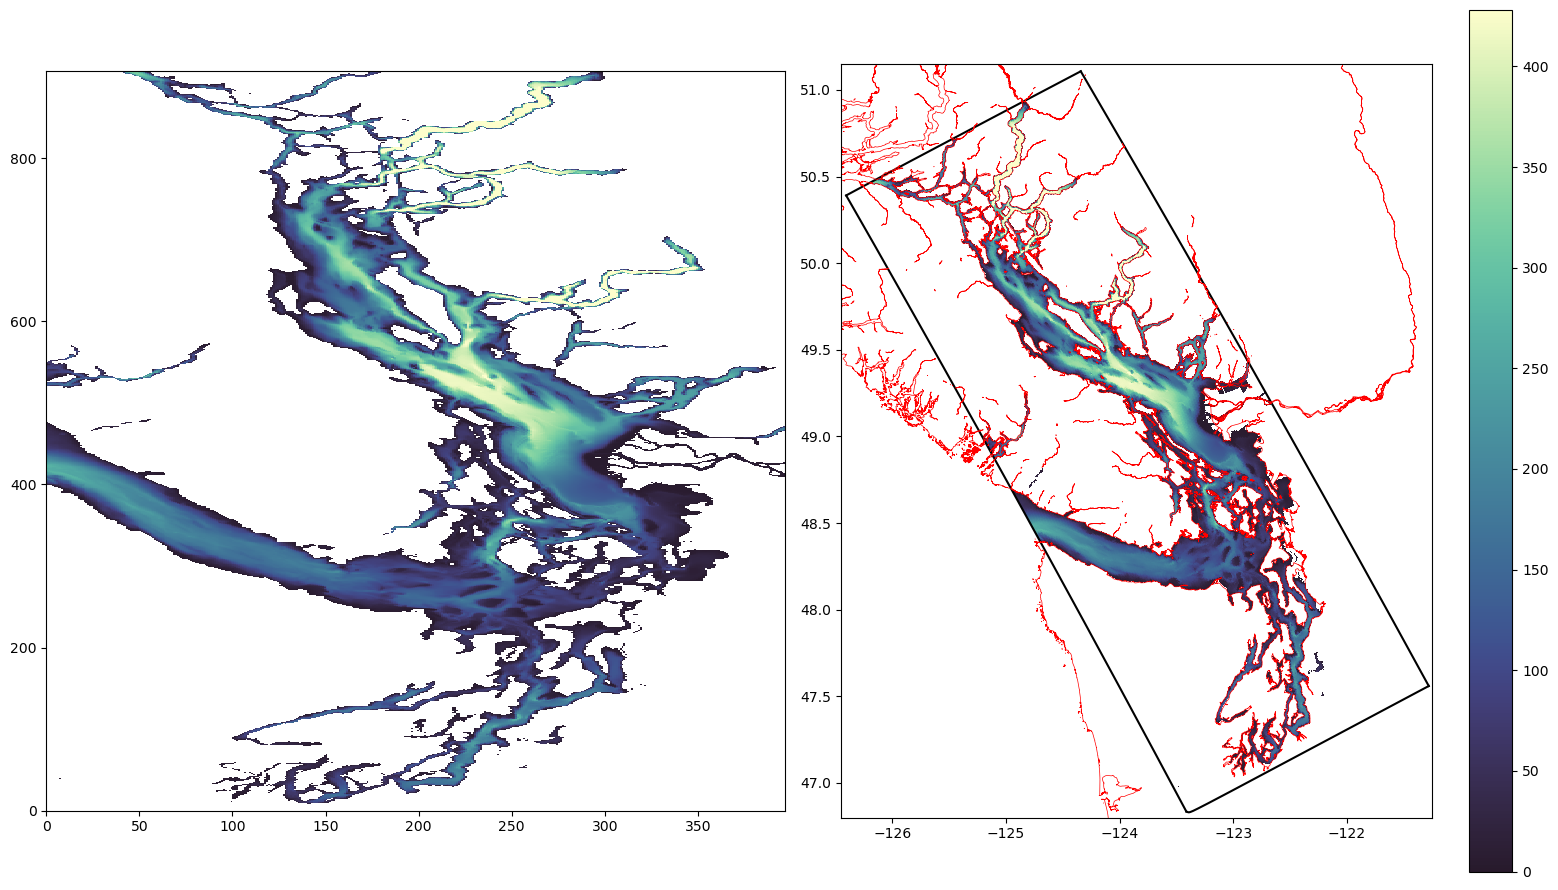

In [24]:
plot_xy_lonlat(bathy_202405, glamfe, gphife, coastline, rivers)

### Truncate Vancouver Harbour etc. at First Narrows

Truncate Vancouver Harbour etc. at First Narrows by setting a line of grid cells to zero depth
so that our function derived from `bathy_helpers.lakefill()` will set to zero the depth of the landlocked grid cells that result.

Zoom to First Narrow region to determine grid cell indices to set zero depth for:

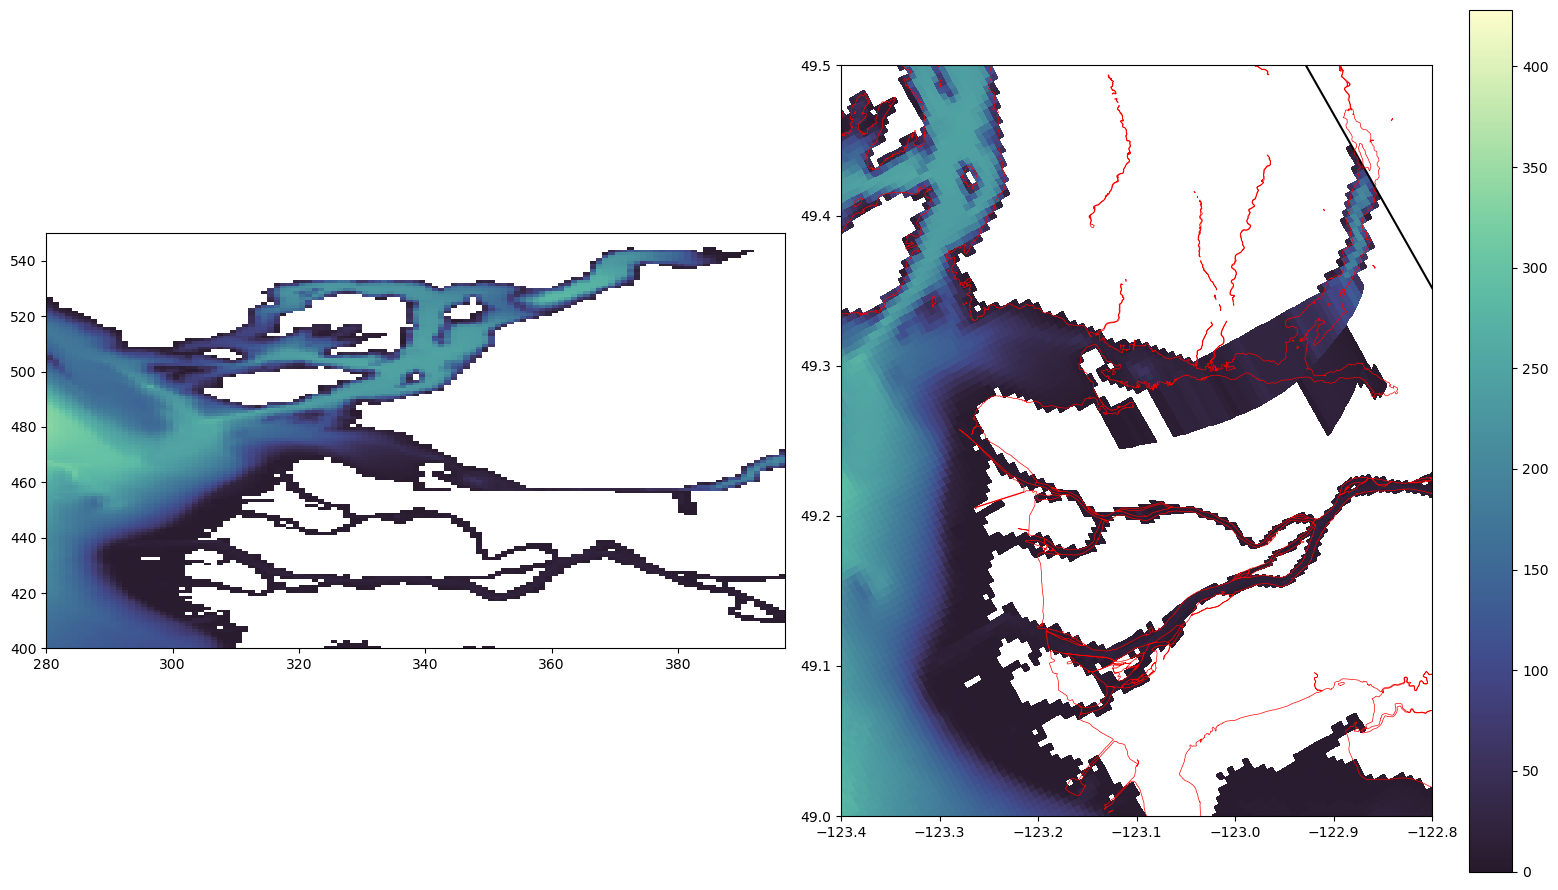

In [25]:
plot_xy_lonlat(bathy_202405, glamfe, gphife, coastline, rivers, x_lims=(280, 397), y_lims=(400, 550), lon_lims=(-123.4, -122.8), lat_lims=(49, 49.5))

In [26]:
van_hrbr_bdy = [(338,460),(339,460),(343,466),(344,466),(344,467),(344,468)]
for i, j in van_hrbr_bdy:
    bathy_202405[j, i] = 0

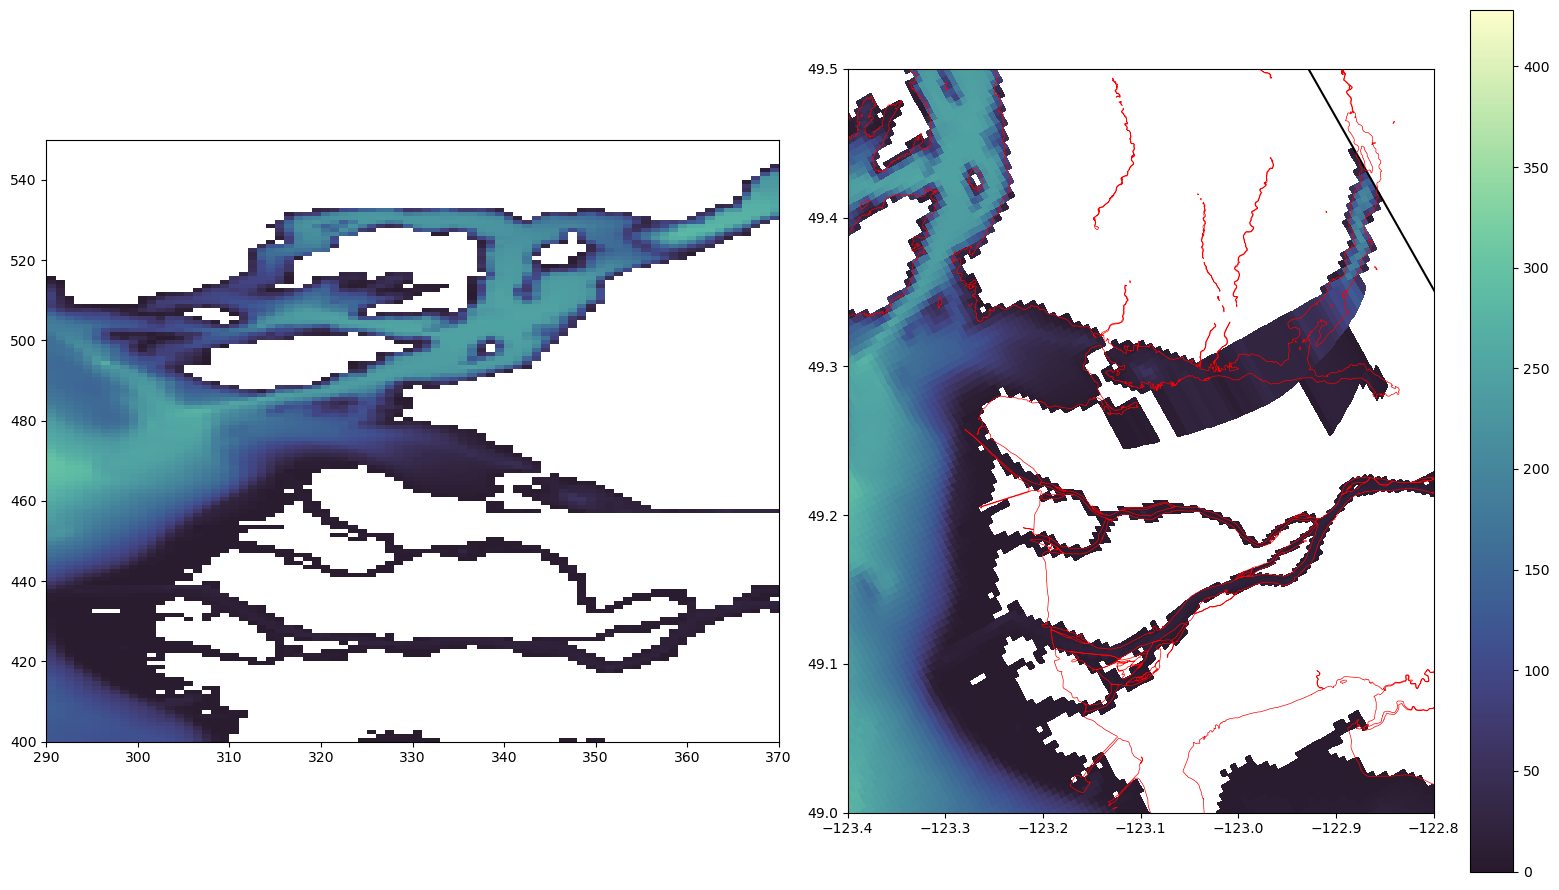

In [27]:
plot_xy_lonlat(bathy_202405, glamfe, gphife, coastline, rivers, x_lims=(290, 370), y_lims=(400, 550), lon_lims=(-123.4, -122.8), lat_lims=(49, 49.5))

Use a tracer diffusion technique from JP and Michael to identify and set to zero depth all landlocked grid cells.

In [28]:
def lakefill(bathy, water_point):
    """Reimplementation of JP's fill_in_lakes.m via Michael's bathy_helpers.lakefill()
    The strategy is to diffuse a tracer from a known water point in the domain
    through the whole domain in 2D. Any non-land points that the tracer
    doesn't reach are lakes, so we fill them.
    """
    # Diffusion domain
    ocean = numpy.zeros(bathy.shape)
    # Get indices of land points from bathymetry and set them as zero depth in diffusion domain
    idxland = bathy == 0
    ocean[idxland] = 0
    # Put tracer at water point in diffusion domain
    x, y = water_point
    ocean[y-1:y+1, x-1:x+1] = 1

    # Diffusion algorithm
    flag, it = True, 0
    stencil = numpy.array([[0,1,0],[1,0,1],[0,1,0]])
    while flag:
        nocean = numpy.sum(ocean)
        it += 1
        ocean = scipy.signal.convolve2d(ocean, stencil, mode='same')
        # Reset bathymetry land points
        ocean[idxland] = 0
        # Anywhere that has tracer is now wet
        ocean[ocean>0] = 1
        flag = numpy.sum(ocean) > nocean

    # Ocean is connected wet points
    idxwater = ocean == 1
    # Lakes are not ocean and not land
    idxlakes = (~idxwater) & (~idxland)
    # Fill the lakes
    bathyout = numpy.copy(bathy)
    bathyout[idxlakes] = 0
    print (f"Lakes filled in {it} iterations")

    return bathyout

In [29]:
bathy_202405 = lakefill(bathy_202405, water_point=(300, 480))

Lakes filled in 750 iterations


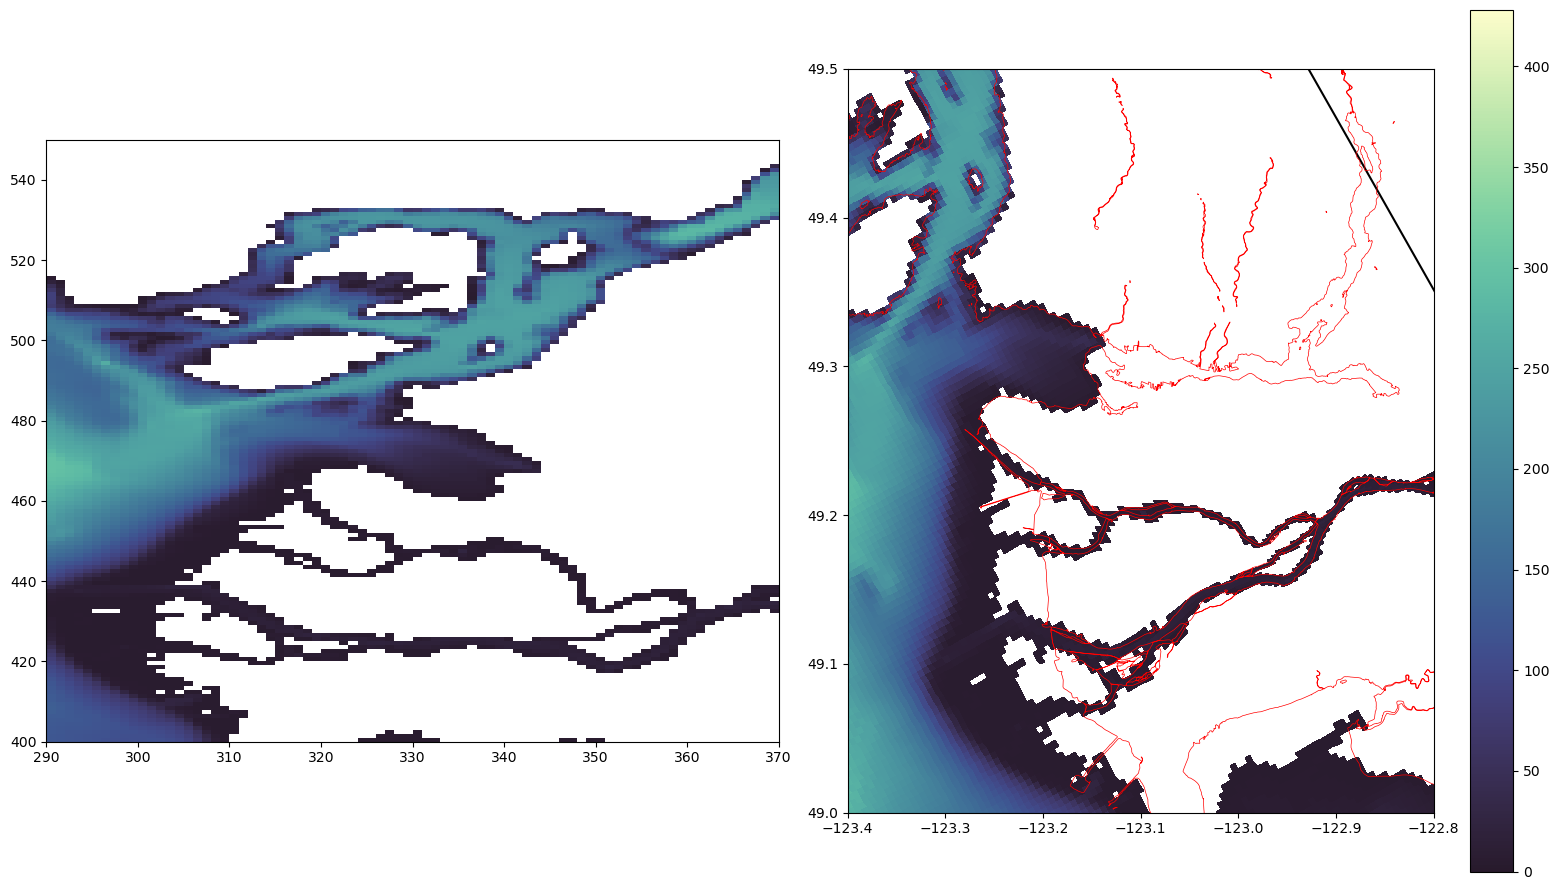

In [30]:
plot_xy_lonlat(bathy_202405, glamfe, gphife, coastline, rivers, x_lims=(290, 370), y_lims=(400, 550), lon_lims=(-123.4, -122.8), lat_lims=(49, 49.5))

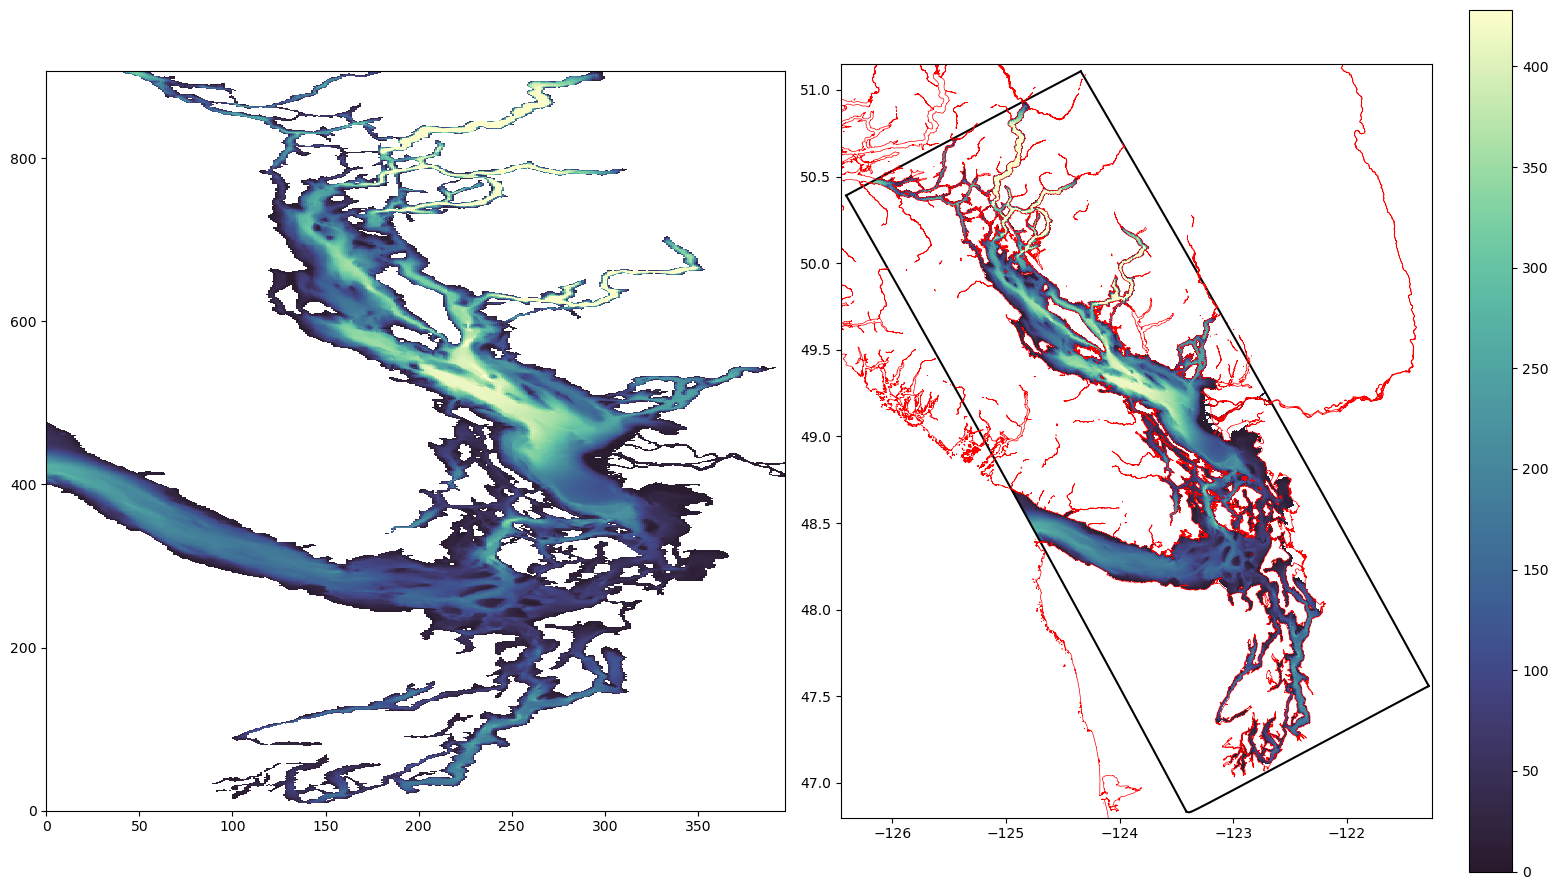

In [31]:
plot_xy_lonlat(bathy_202405, glamfe, gphife, coastline, rivers)

### Truncate Pitt River

Truncate the Pitt River near its confluence with the Fraser River.
We don't want it to be an open boundary.

Zoom to Fraser River region to determine grid cell indices to set zero depth for:

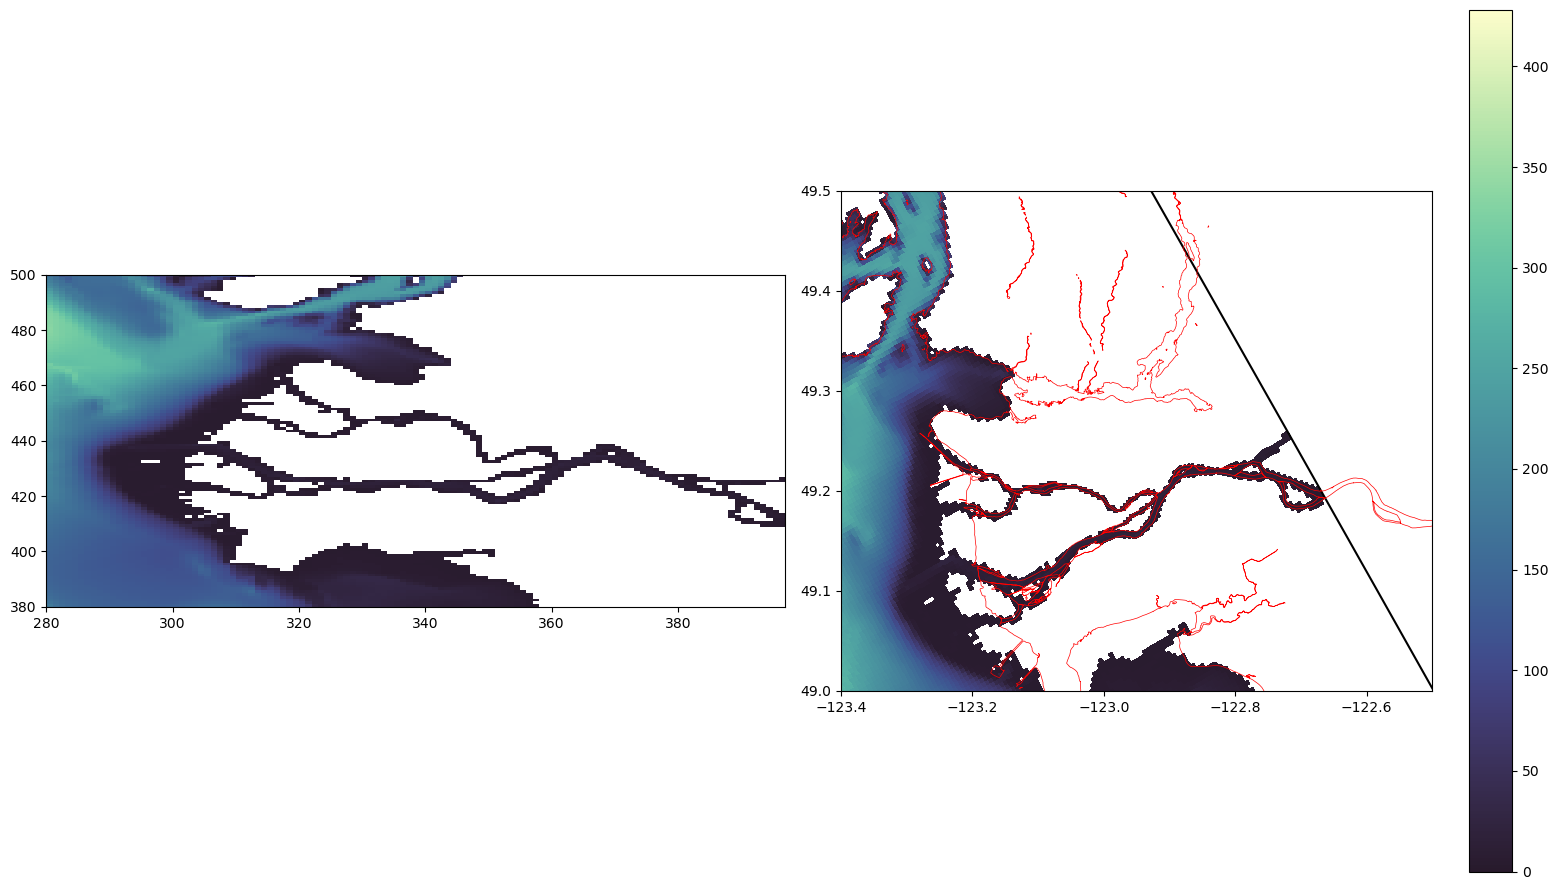

In [32]:
plot_xy_lonlat(bathy_202405, glamfe, gphife, coastline, rivers, x_lims=(280, 397), y_lims=(380, 500), lon_lims=(-123.4, -122.5), lat_lims=(49, 49.5))

In [33]:
pitt_cut = [(396, j) for j in range(425, 435)]
for i, j in pitt_cut:
    bathy_202405[j, i] = 0


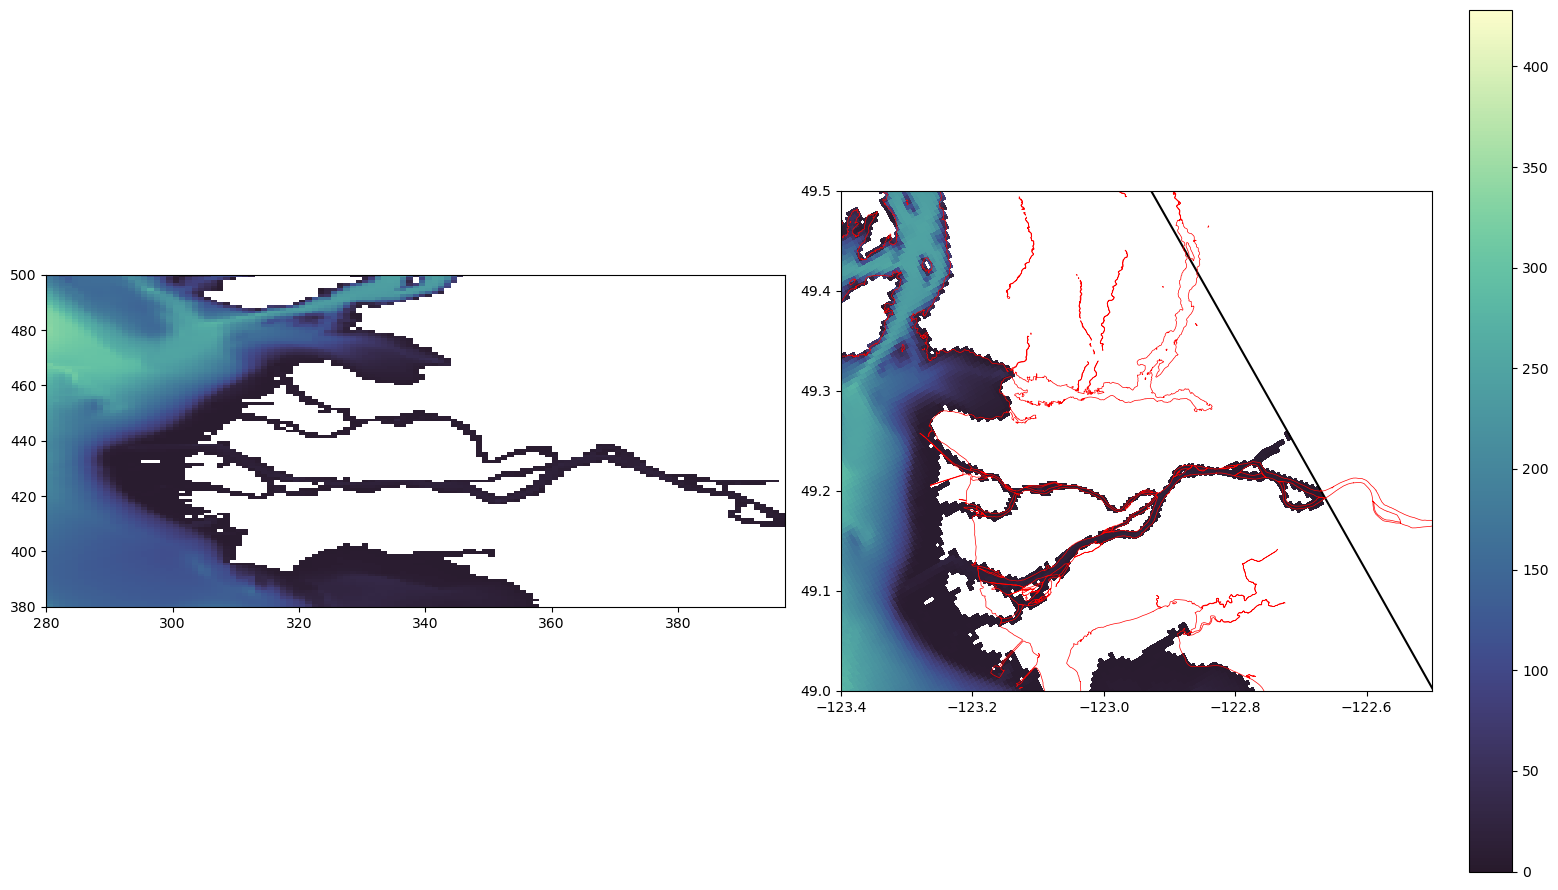

In [34]:
plot_xy_lonlat(bathy_202405, glamfe, gphife, coastline, rivers, x_lims=(280, 397), y_lims=(380, 500), lon_lims=(-123.4, -122.5), lat_lims=(49, 49.5))

### Change Fraser River to Proxy Shape

Change Fraser River upstream of Port Mann Bridge area from its real shape to a proxy shape.
The proxy shape is a strait extension in the negative y direction from the actual river.
It provides sufficient river length for an acceptable representation of the tidal currents
in the section of the river that is tidally influenced.

In [35]:
fraser_cut = [(i, 418) for i in range(385, 395)]
for i, j in fraser_cut:
    bathy_202405[j, i] = 0


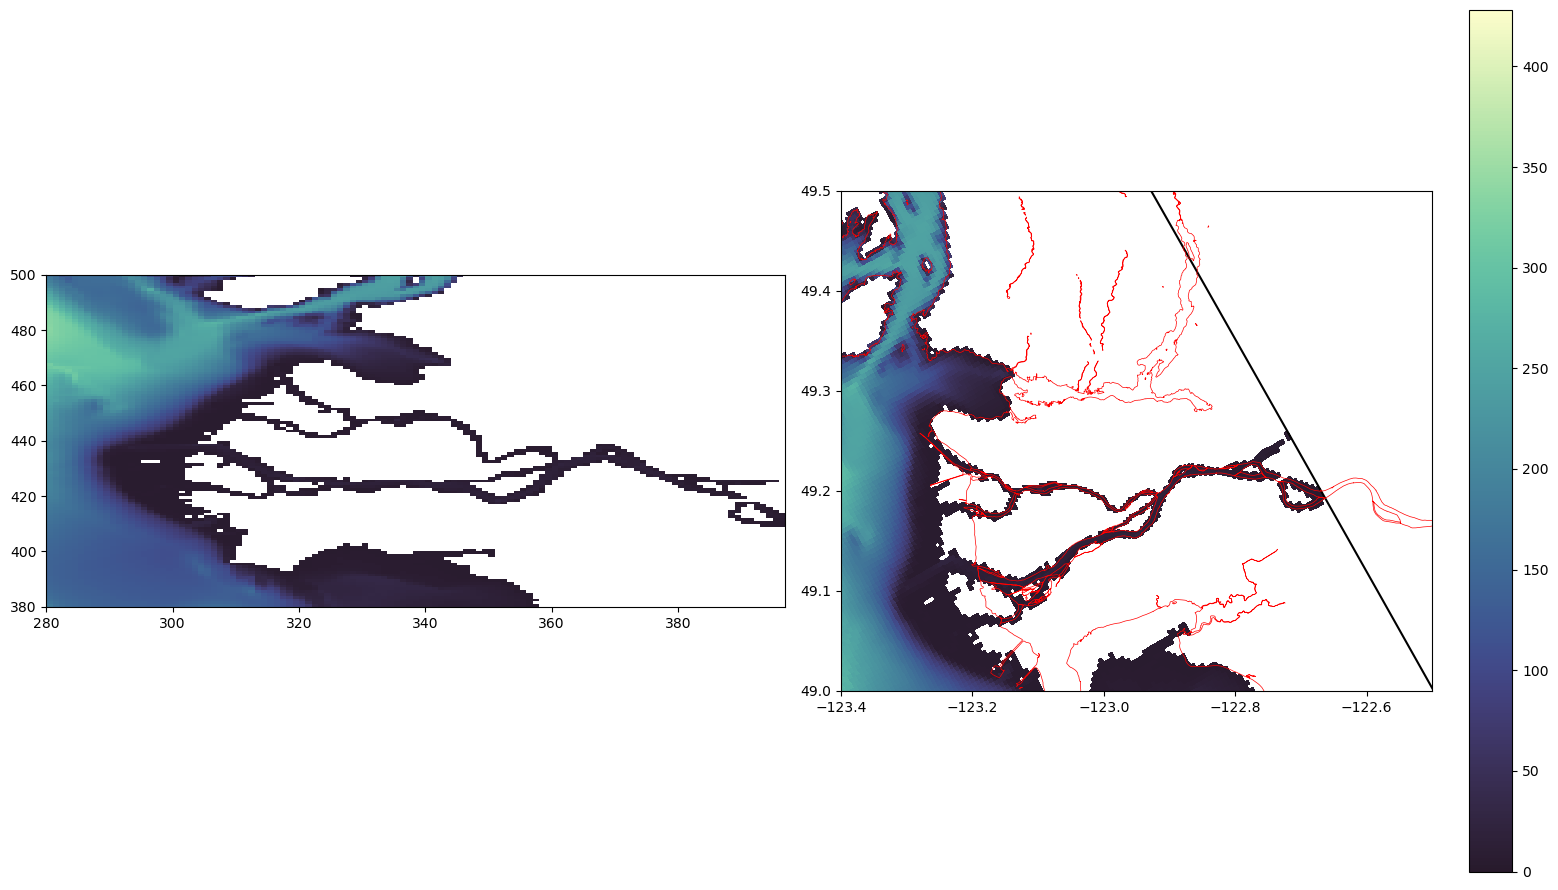

In [36]:
plot_xy_lonlat(bathy_202405, glamfe, gphife, coastline, rivers, x_lims=(280, 397), y_lims=(380, 500), lon_lims=(-123.4, -122.5), lat_lims=(49, 49.5))

In [37]:
bathy_202405 = lakefill(bathy_202405, water_point=(300, 480))

Lakes filled in 750 iterations


Add the proxy Fraser River extension to the south:

In [38]:
fraser_extension = [(391, j) for j in range(419, 330, -1)]
for i, j in fraser_extension:
    bathy_202405[j, i] = 10


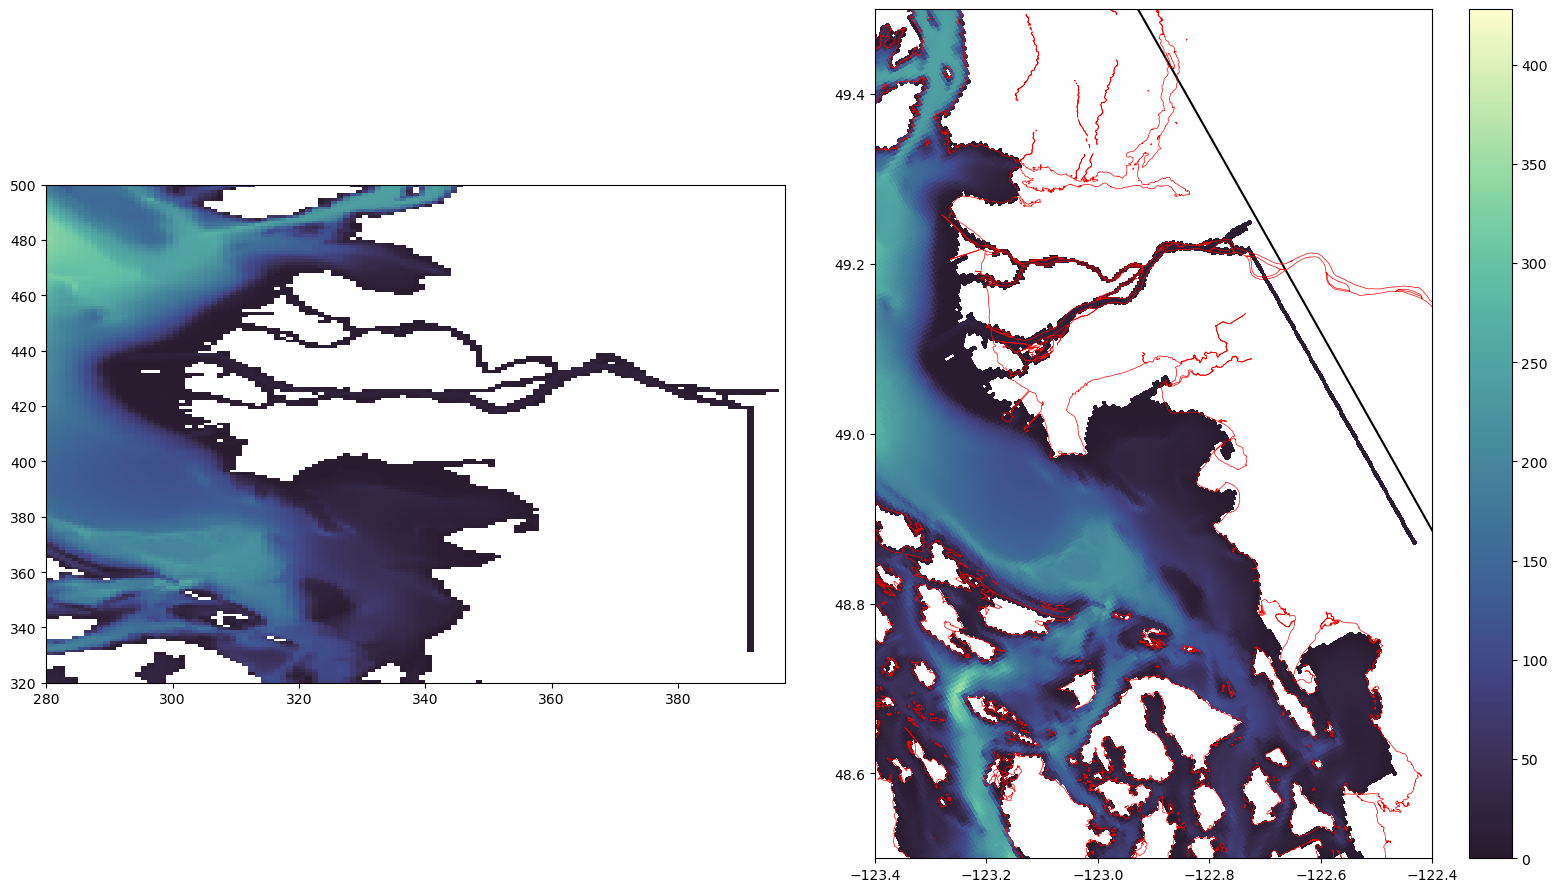

In [39]:
plot_xy_lonlat(bathy_202405, glamfe, gphife, coastline, rivers, x_lims=(280, 397), y_lims=(320, 500), lon_lims=(-123.4, -122.4), lat_lims=(48.5, 49.5))

In [40]:
bathy_202405 = lakefill(bathy_202405, water_point=(300, 480))

Lakes filled in 750 iterations


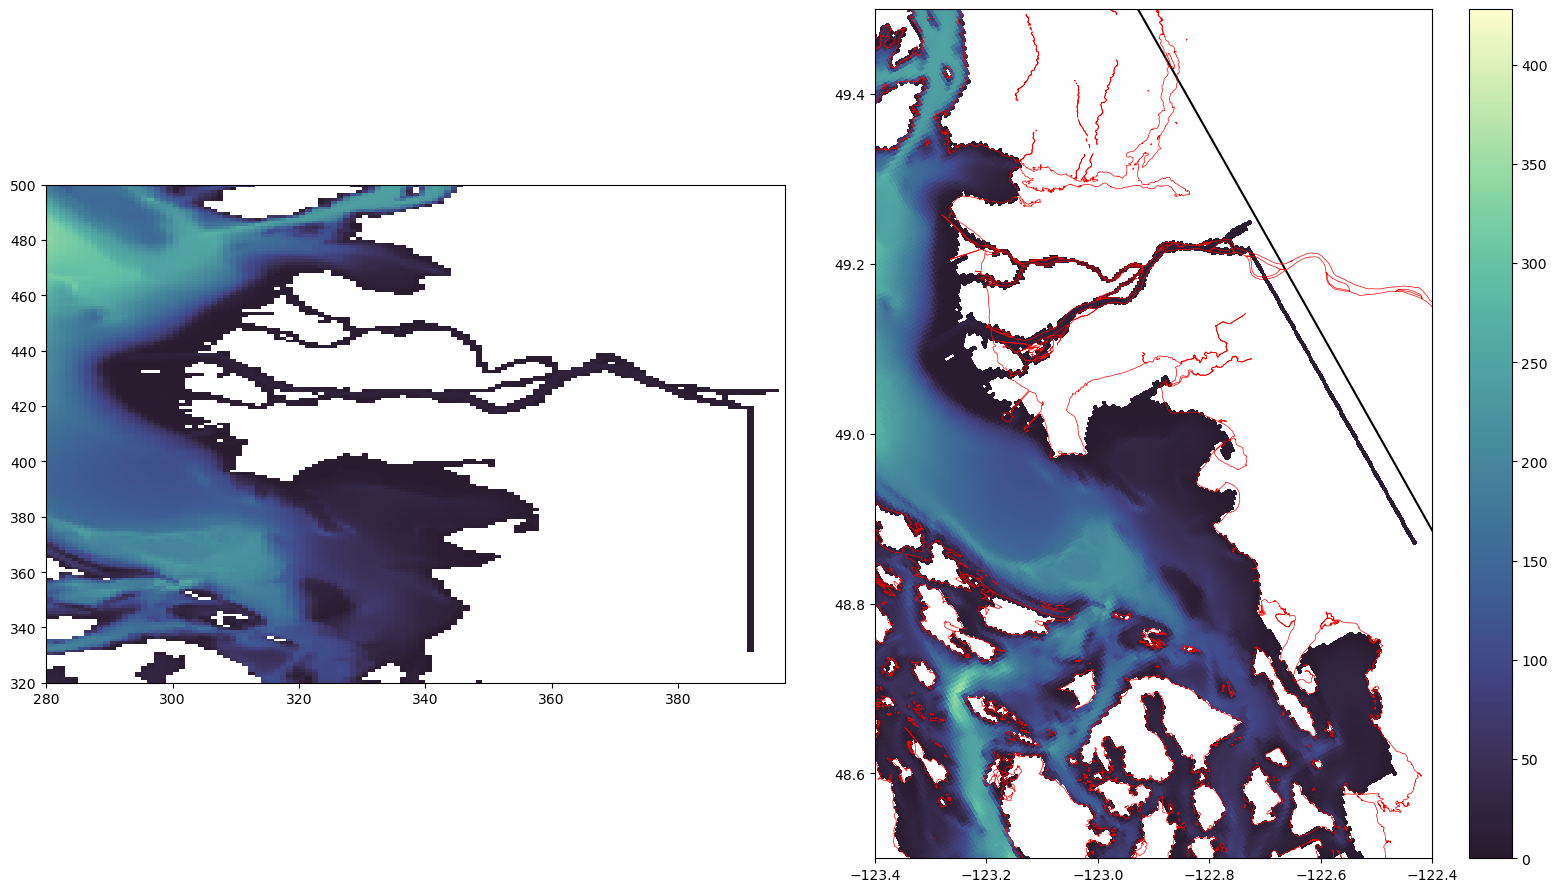

In [41]:
plot_xy_lonlat(bathy_202405, glamfe, gphife, coastline, rivers, x_lims=(280, 397), y_lims=(320, 500), lon_lims=(-123.4, -122.4), lat_lims=(48.5, 49.5))

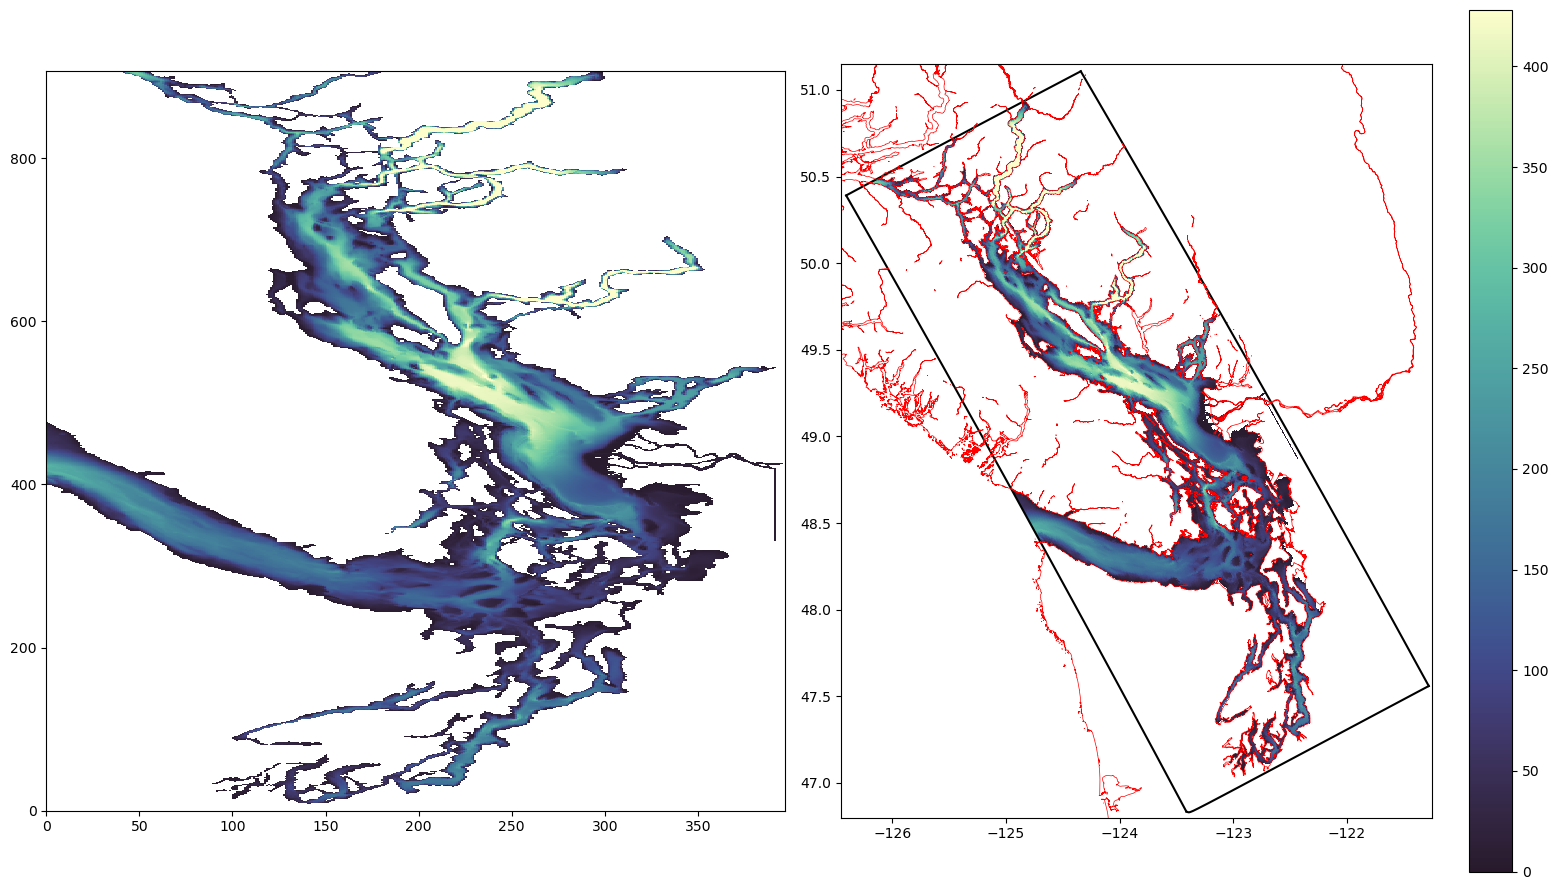

In [42]:
plot_xy_lonlat(bathy_202405, glamfe, gphife, coastline, rivers)

### Store Base Bathymetry in a netCDF File

We now have the base bathymetry.
It has to be further processed by following Susan's notebooks:
  * `tools/bathymetry/Process202108Bathymetry.ipynb`
  * `analysis-susan/notebooks/bathymetry/lookat201702_201803d_andrivers.ipynb`
  * `analysis-susan/notebooks/bathymetry/lookat201702_201803d_middle.ipynb`
  * `analysis-susan/notebooks/bathymetry/lookat201702_201803d-upper.ipynb`

Here,
we store the base bathymetry dataset in a netCDF file that we can read at the beginning of the next processing step.

In [43]:
base_bathy_paths = {
    "djl_202405": repos_prefix / "grid" / "bathymetry_202405_base.nc",
    "dbl_202405": repos_prefix / "grid" / "bathymetry_double_202405_base.nc",
}

In [44]:
djl_202405_ds = xarray.Dataset(
    data_vars={
        "Bathymetry": xarray.DataArray(
            data=bathy_202405,
            dims=["y", "x"],
            attrs={
                "long_name": "sea_floor_depth",
                "units": "m",
            },
        ),
        "nav_lat": xarray.DataArray(
            data=gphit,
            dims=["y", "x"],
            attrs={
                "long_name": "latitude",
                "units": "degrees_north",
            },
        ),
        "nav_lon": xarray.DataArray(
            data=glamt,
            dims=["y", "x"],
            attrs={
                "long_name": "longitude",
                "units": "degrees_east",
            },
        ),
    },
    coords={
        "y": numpy.arange(bathy_202405.shape[0], dtype=int),
        "x": numpy.arange(bathy_202405.shape[1], dtype=int),
    },
    attrs={
        "Conventions": "CF-1.6",
        "title": "Bathymetry 202405 base",
        "institution": "Dept of Earth, Ocean & Atmospheric Sciences, University of British Columbia",
        "source": "Bathymetry products from Cascadia, BC3, and CHS2 via analysis-doug/notebooks/2xrez-202111/bathymetry-202405.ipynb",
        "history": f"[{arrow.now():YYYY-MM-DD HH:mm:ss}] Created.",
    },
)

djl_202405_ds

<xarray.Dataset> Size: 9MB
Dimensions:     (y: 908, x: 398)
Coordinates:
  * y           (y) int64 7kB 0 1 2 3 4 5 6 7 ... 901 902 903 904 905 906 907
  * x           (x) int64 3kB 0 1 2 3 4 5 6 7 ... 391 392 393 394 395 396 397
Data variables:
    Bathymetry  (y, x) float64 3MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    nav_lat     (y, x) float64 3MB 46.84 46.83 46.83 46.83 ... 51.1 51.1 51.1
    nav_lon     (y, x) float64 3MB -123.4 -123.4 -123.4 ... -124.4 -124.3 -124.3
Attributes:
    Conventions:  CF-1.6
    title:        Bathymetry 202405 base
    institution:  Dept of Earth, Ocean & Atmospheric Sciences, University of ...
    source:       Bathymetry products from Cascadia, BC3, and CHS2 via analys...
    history:      [2025-02-13 08:59:53] Created.

In [45]:
encoding = {
    "Bathymetry": {"zlib": True, "complevel": 4},
    "nav_lat": {"zlib": True, "complevel": 4},
    "nav_lon": {"zlib": True, "complevel": 4},
}
djl_202405_ds.to_netcdf(base_bathy_paths["djl_202405"], encoding=encoding, engine="netcdf4")